# Part 3: Serving

In this part we will user MLRun's **serving runtime** to deploy our trained models from the previous stage a `Voting Ensemble` using **max vote** logic.  
We will also use MLRun's **Feature store** to receive the latest tag of the online **Feature Vector** we defined in the preveious stage.

By the end of this tutorial you’ll learn how to:
- Define a model class to load our models, run preprocessing and predict on the data
- Define Voting Ensemble function on top of our models
- Test the serving function locally using our `mock server`
- Deploy the function to the cluster and test it live

## Environment Setup

Since our work is done in a this project scope, we will first want to define the project itself for all our MLRun work in this notebook.

In [1]:
import mlrun
project_name, _ = mlrun.set_environment(project='fraud-demo', 
                                        user_project=True)

> 2021-08-26 10:18:57,829 [info] loaded project fraud-demo-admin from MLRun DB


## Define Model Class
- Load models
- Predict from the FS Online service via the `source` key

In [2]:
# mlrun: start-code

In [3]:
import os
from typing import Optional

import numpy as np
import pandas as pd
from cloudpickle import load
import json

import mlrun
from mlrun.feature_store import OnlineVectorService, get_online_feature_service
from mlrun.serving.routers import VotingEnsemble
from mlrun.serving.v2_serving import V2ModelServer


class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()
    
    
class EnrichmentVotingEnsemble(VotingEnsemble):
    def __init__(
        self,
        context,
        name,
        routes=None,
        protocol=None,
        url_prefix=None,
        health_prefix=None,
        vote_type=None,
        executor_type=None,
        prediction_col_name=None,
        feature_vector_uri: str = "",
        **kwargs,
    ):
        super().__init__(
            context,
            name,
            routes,
            protocol,
            url_prefix,
            health_prefix,
            vote_type,
            executor_type,
            prediction_col_name,
            **kwargs,
        )

        self.feature_vector_uri = feature_vector_uri
        self.feature_service: Optional[OnlineVectorService] = None
        self.feature_stats: Optional[pd.DataFrame] = None
        self.default_category = 0

    def post_init(self, mode="sync"):
        super().post_init(mode)
        
        self.feature_service: OnlineVectorService = get_online_feature_service(
            feature_vector=self.feature_vector_uri
        )
        self.feature_stats = self.feature_service.vector.get_stats_table()

    def preprocess(self, event):
        
        if isinstance(event.body,str) or isinstance(event.body,bytes):
            event.body = json.loads(event.body)

        """Turn an entity identifier (source) to a Feature Vector"""
        # Get patient feature vector"
        # from the patient_id given in the request
        print("event body:", event.body)
        inputs = event.body['inputs']
        
        sources = [{"source": source} for source in inputs]
        print("sources:", sources)
            
        print(type(sources))
        print(sources)
        # here it is not serializing, error:
        vectors = self.feature_service.get(sources)
        print("vectors:", vectors)
        
        # Impute inf's in the data to the feature's mean value
        # using the collected statistics from the Feature store
        feature_vectors = []
        for fv in vectors:
            if fv is None:
                continue
            new_vector = []
            for f, v in fv.items():
                if type(v) == float:
                    if np.isinf(v) or np.isnan(v):
                        new_vector.append(self.feature_stats.loc[f, "mean"])
                    else:
                        new_vector.append(v)
                    continue
                v = v if v is not None else self.default_category
                new_vector.append(v)
            feature_vectors.append(new_vector)

        # Set the final feature vector as our inputs
        # to pass to the predict function
        event.body["inputs"] = feature_vectors
        
        return event

In [4]:
# mlrun: end-code

## Define Serving Function
- Gather ClassifierModel code from this notebook
- Define `VotingEnsemble` - Max-Vote based ensemble
- Add downloaded models to the ensemble

In [5]:
feature_service: OnlineVectorService = get_online_feature_service(
    feature_vector="transactions-fraud-short"
)

In [6]:
feature_service.get([{"source": "C1000148617"}])

[{'amount_max_2h': -inf,
  'amount_max_12h': 47.42,
  'amount_sum_2h': 0.0,
  'amount_count_2h': 0.0,
  'amount_avg_2h': nan}]

In [7]:
MODEL_MONITORING_ACCESS_KEY = os.getenv('V3IO_ACCESS_KEY')

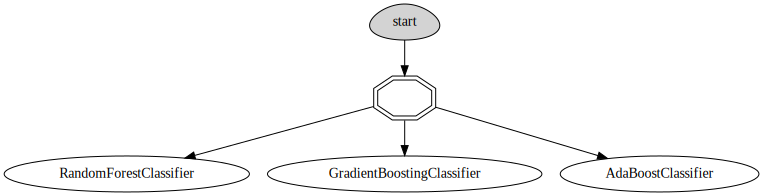

In [8]:
from mlrun import mount_v3io

db = mlrun.get_run_db()

db.create_project_secrets(
    project_name,
    provider=mlrun.api.schemas.SecretProviderName.kubernetes,
    secrets={"MODEL_MONITORING_ACCESS_KEY": MODEL_MONITORING_ACCESS_KEY}
)

# Create the serving function from our code above
# namespace/image_name:tag
fn = mlrun.code_to_function('transaction-fraud', kind='serving', image="mlrun/mlrun")

# Model-monitoring
fn.set_tracking()
fn.metadata.project = project_name

# 
fn.set_topology('router', 'EnrichmentVotingEnsemble', name='VotingEnsemble',
                feature_vector_uri="transactions-fraud-short")

# Apply a mount so we can load the model files directly from the v3io fs
fn.apply(mount_v3io())

model_names = [
'RandomForestClassifier',
'GradientBoostingClassifier',
'AdaBoostClassifier'
]

models_dir = os.path.abspath('models')

for i, name in enumerate(model_names, start=1):
    fn.add_model(name, class_name="ClassifierModel", model_path=f"store://models/{project_name}/training_model#{i}:latest")

# Plot the ensemble configuration
fn.spec.graph.plot()

## Test the server locally

### View a sample of the online features

In [9]:
import mlrun.feature_store as fs

# Create the online feature service
svc = fs.get_online_feature_service(f'{project_name}/transactions-fraud-short:latest')

# Get sample feature vector
sample_id = 'C76780537'
sample_fv = svc.get([{'source': sample_id}])
sample_fv

[{'amount_max_2h': -inf,
  'amount_max_12h': 25.83,
  'amount_sum_2h': 0.0,
  'amount_count_2h': 0.0,
  'amount_avg_2h': nan}]

In [10]:
import json

# Send a sample ID for predcition
test_path = f'/v2/models/VotingEnsemble/infer'
test_sample = json.dumps({'inputs': [sample_id]})

In [11]:
# server.test(path=test_path,
#             body=test_sample)

In [12]:
test_sample

'{"inputs": ["C76780537"]}'

### Test the function on the kubernetes cluster

#### Deploy

In [13]:
addr = fn.deploy()

> 2021-08-26 10:19:13,494 [info] Starting remote function deploy
2021-08-26 10:19:14  (info) Deploying function
2021-08-26 10:19:14  (info) Building
2021-08-26 10:19:15  (info) Staging files and preparing base images
2021-08-26 10:19:15  (info) Building processor image
2021-08-26 10:19:16  (info) Build complete
2021-08-26 10:19:22  (info) Function deploy complete
> 2021-08-26 10:19:23,149 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['default-tenant.app.hwwrtxdzgakc.iguazio-cd0.com:30033']}


In [14]:
import pandas as pd
from random import choice

# Load the dataset
data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# Sample 50k lines
data = data.sample(50000)

sample_ids = data['source'].to_list()

In [15]:
from random import choice, uniform
from time import sleep

# Sending random requests
for _ in range(4000):
    data_point = choice(sample_ids)
    try:
        fn.invoke(path=test_path, body=json.dumps({'inputs': [data_point]}))
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

> 2021-08-26 10:19:31,012 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}
> 2021-08-26 10:19:31,620 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}
> 2021-08-26 10:19:31,930 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}
> 2021-08-26 10:19:32,333 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}
> 2021-08-26 10:19:32,602 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}


KeyboardInterrupt: 

# Stream Testing!

In [ ]:
import v3io
import nuclio

# create stream
prediction_stream = f'v3io:///projects/{project_name}/streams/transaction_fraud_stream'
client = v3io.dataplane.Client()

In [ ]:
client.stream.create(container='projects',
                 stream_path=f'{project_name}/streams/transaction_fraud_stream',
                 shard_count=2, raise_for_status=v3io.dataplane.transport.RaiseForStatus.never)

In [ ]:
data = {'operation': 'infer',
        'model': 'VotingEnsemble',
        'inputs': [sample_id]}

rec = client.stream.put_records(container='projects',
                                stream_path=f'{project_name}/streams/transaction_fraud_stream',
                                records=[{'data': json.dumps(data)}])

In [ ]:
rec.headers

In [ ]:
stream_trigger = nuclio.triggers.V3IOStreamTrigger()
fn.add_v3io_stream_trigger(f'v3io:///projects/{project_name}/streams/transaction_fraud_stream')
fn.deploy()